# Deep learning for classification tasks

In [1]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

### MNIST classification. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]
test_size = digits_test.shape[0]

input_size = 8*8
classes_n = 10

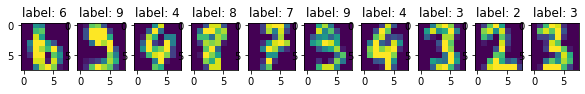

In [ ]:
N = 10

sample_idx = np.random.choice(1797, N, replace=False)
digits_sample = digits[sample_idx]
targets_sample = targets[sample_idx]
f, ax  = plt.subplots(1,10, figsize=(10, 5))

for i in range(N):
    ax[i].imshow(digits_sample[i].reshape(8,8))
    ax[i].set_title('label: '+str(targets_sample[i]))


**Implementing the MLP with backprop**

In [ ]:

class Linear:
    def __init__(self, input_size, output_size):
        # Trainable parameters of the layer and their gradients
        self.thetas = np.random.randn(input_size, output_size) # the weight matrix of the layer (W)
        self.thetas_grads = np.empty_like(self.thetas) # gradient w.r.t. the weight matrix of the layer
        self.bias = np.random.randn(output_size) # bias terms of the layer (b)
        self.bias_grads = np.empty_like(self.bias) # gradient w.r.t. bias terms of the linear layer

    def forward(self, x): 
        self.x = x
        output = np.matmul(x, self.thetas) + self.bias
        return output
    
    def backward(self, output_grad, learning_rate):

        input_grad = np.matmul(output_grad, self.thetas.T)
        self.thetas_grads = np.matmul(self.x.T, output_grad)
        self.bias_grads = output_grad.reshape(-1)
        self.step(learning_rate)

        return input_grad

    def step(self, learning_rate):
        self.thetas -= self.thetas_grads * learning_rate
        self.bias -= self.bias_grads * learning_rate

class LogisticActivation:
    def __init__(self):
        # the layer has no parameters
        pass 
        
    def sig(self, x):
        return 1/(1 + np.exp(-x))

    def forward(self, x):
        self.o = self.sig(x)
        return self.o 


    def backward(self,  output_grad, learning_rate=None):

        input_grad = output_grad*(self.o*(1-self.o))

        return input_grad


class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        h1 = self.linear1.forward(x)
        h1a = self.activation1.forward(h1)
        out = self.linear2.forward(h1a)
        return out

    def backward(self, output_grad, learning_rate):

        grad_linear2 = self.linear2.backward(output_grad, learning_rate)
        grad_activation1= self.activation1.backward(grad_linear2, learning_rate=None)
        grad_linear1 = self.linear1.backward(grad_activation1, learning_rate)
        out = grad_linear1        

        return  out


In [ ]:
def softmax_crossentropy_with_logits(logits, reference_answers):

    n,m = logits.shape
    true_answers = np.zeros((n,m))
    true_answers[np.arange(n), reference_answers] = 1
    softmax_probs = F.softmax(torch.tensor(logits), dim=1)
    Loss = - torch.mean(torch.sum(torch.log(softmax_probs) * torch.tensor(true_answers), dim=1), dim=0)
    loss=Loss.numpy()

    return loss

def grad_softmax_crossentropy_with_logits(logits, reference_answers):

    n,m = logits.shape
    true_answers = np.zeros((n,m))
    true_answers[np.arange(n), reference_answers] = 1
    softmax_probs = F.softmax(torch.tensor(logits), dim=1)
    grad = softmax_probs - torch.tensor(true_answers)
    grad = grad.numpy()

    return grad

In [ ]:
np.random.seed(42)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 100
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-2

for epoch in range(epochs_n):
    
    y_pred = []

    for sample_i in range(train_size):
        x = x_train[sample_i].reshape((1, -1))
        target = np.array([y_train[sample_i]])
        logits = mlp.forward(x)

        loss = softmax_crossentropy_with_logits(logits, target)
        grad = grad_softmax_crossentropy_with_logits(logits, target)
        gradient = mlp.backward(grad, learning_rate)

        y_pred.extend(logits.argmax(1))

    if epoch % 10 == 0:
        
        y_pred_test = []

        for sample_i in range(test_size):
            x = x_test[sample_i].reshape((1, -1))
            target = np.array([y_test[sample_i]])
            
            logits = mlp.forward(x)
            y_pred_test.extend(logits.argmax(1))

        print('Starting epoch {}'.format(epoch), \
              ', Loss : {:.3}'.format(loss), \
              ', Accuracy on train: {:.3}'.format(accuracy_score(y_train, y_pred)), \
              ', Accuracy on test: {:.3}'.format(accuracy_score(y_test, y_pred_test)) )

Starting epoch 0 , Loss : 2.71 , Accuracy on train: 0.103 , Accuracy on test: 0.0667
Starting epoch 10 , Loss : 2.15 , Accuracy on train: 0.625 , Accuracy on test: 0.649
Starting epoch 20 , Loss : 1.55 , Accuracy on train: 0.821 , Accuracy on test: 0.807
Starting epoch 30 , Loss : 1.07 , Accuracy on train: 0.875 , Accuracy on test: 0.871
Starting epoch 40 , Loss : 0.742 , Accuracy on train: 0.9 , Accuracy on test: 0.889
Starting epoch 50 , Loss : 0.534 , Accuracy on train: 0.911 , Accuracy on test: 0.904
Starting epoch 60 , Loss : 0.399 , Accuracy on train: 0.92 , Accuracy on test: 0.924
Starting epoch 70 , Loss : 0.308 , Accuracy on train: 0.927 , Accuracy on test: 0.931
Starting epoch 80 , Loss : 0.245 , Accuracy on train: 0.929 , Accuracy on test: 0.931
Starting epoch 90 , Loss : 0.198 , Accuracy on train: 0.936 , Accuracy on test: 0.933


## CIFAR-10 Classification

In [ ]:
import torch
import torchvision
from torch import nn
from tqdm import tqdm

**Data transformation and normalisation**

In [ ]:
from torchvision.transforms.transforms import Normalize

torch.manual_seed(0)


train_transform = torchvision.transforms.Compose([
                  torchvision.transforms.RandomHorizontalFlip(),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

test_transform = torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10('./cifar', train=True, transform=train_transform, download=True )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, num_workers=2, shuffle=True )

test_set = torchvision.datasets.CIFAR10('./cifar', train=False, transform=test_transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, num_workers=2, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Train size', len(train_set))
print('Test size', len(test_set))

Files already downloaded and verified
Files already downloaded and verified
Train size 50000
Test size 10000


**Examples of our data for random batch**

In [ ]:
def plot_random_images(loader):
    torch.manual_seed(0)

    inv_normalize = torchvision.transforms.Normalize(
                      mean=[-1, -1, -1],
                      std=[1/0.5, 1/0.5, 1/0.5])

    inputs, labels = next(iter(loader))
    
    fig, ax = plt.subplots(1,loader.batch_size, figsize=(20,15))

    inv_inputs = inv_normalize(inputs)

    for i in range(loader.batch_size):
      ax[i].imshow(inv_inputs[i].numpy().transpose(1,2,0))
      ax[i].set_title(classes[labels[i].numpy()])
      ax[i].axis('off')

Train (augmented) images.


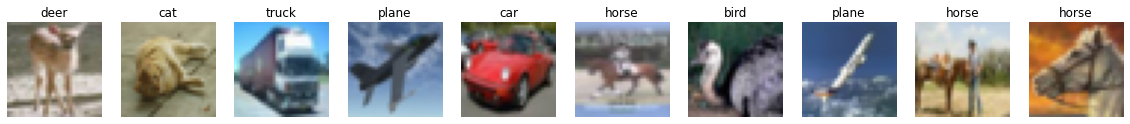

In [ ]:
print('Train (augmented) images.')
plot_random_images(train_loader)

Test images (no augmentation).


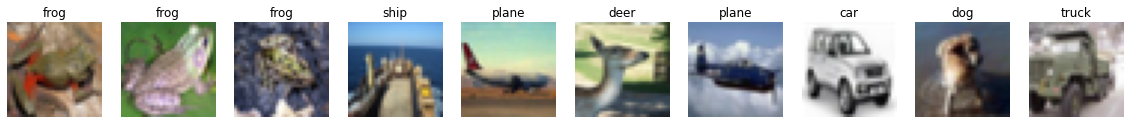

In [ ]:
print('Test images (no augmentation).')
plot_random_images(test_loader)

### Training procedure + linear classification

In [ ]:
from torch.cuda import ComplexFloatStorage
def epoch_train(loader, clf, criterion, opt):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    clf = clf.to(device)  
    clf.train(True)

    train_loss = 0
    correct = 0

    for batch_i, (data,labels) in enumerate(loader):
      
      data = data.to(device)
      labels = labels.to(device)
      clf_out = clf(data)
      prediction = clf_out.argmax(dim=-1, keepdim=True)
      loss = criterion(clf_out , labels)
      train_loss+=loss.item()*data.shape[0]
      opt.zero_grad()
      loss.backward()
      opt.step()
      correct += prediction.eq(labels.view_as(prediction)).sum().item()
    train_accuracy = correct / len(loader.dataset)
    return (train_loss)/len(loader.dataset), train_accuracy

def epoch_test(loader, clf, criterion):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    clf = clf.to(device)
    clf.eval()

    test_loss = 0
    correct = 0

    for batch_i, (data,labels) in enumerate(loader):

      data = data.to(device)
      labels = labels.to(device)
      clf_out = clf(data)
      prediction = clf_out.argmax(dim=-1, keepdim=True)
      loss = criterion(clf_out , labels)
      test_loss+=loss.item()*data.shape[0]
      correct += prediction.eq(labels.view_as(prediction)).sum().item()
    test_accuracy = correct / len(loader.dataset)
    return (test_loss)/len(loader.dataset), test_accuracy

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

**Defining a Liniar Classifier**

In [ ]:
class LINEAR(nn.Module):
    def __init__(self, num_classes=10):
        super(LINEAR, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)
    
clf_lr = LINEAR(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_lr.parameters()]))

Number of weights: 30730


**Definig data augmentations and optimiser**

In [ ]:
torch.manual_seed(0)

train_transform = torchvision.transforms.Compose([
                  torchvision.transforms.RandomHorizontalFlip(),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

test_transform = torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10('./cifar', train=True, transform=train_transform, download=True )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=60, num_workers=2, shuffle=True )

test_set = torchvision.datasets.CIFAR10('./cifar', train=False, transform=test_transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=60, num_workers=2, shuffle=True)

opt = torch.optim.SGD(clf_lr.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


**Liniar Classifier training process**

In [ ]:
train(train_loader, test_loader, clf_lr, criterion, opt, n_epochs=20)

  5%|▌         | 1/20 [00:19<06:17, 19.86s/it]

[Epoch 1] train loss: 1.843; train acc: 0.36; test loss: 1.764; test acc: 0.40


 10%|█         | 2/20 [00:44<06:50, 22.83s/it]

[Epoch 2] train loss: 1.760; train acc: 0.40; test loss: 1.739; test acc: 0.40


 15%|█▌        | 3/20 [01:06<06:22, 22.50s/it]

[Epoch 3] train loss: 1.736; train acc: 0.40; test loss: 1.738; test acc: 0.39


 20%|██        | 4/20 [01:27<05:47, 21.70s/it]

[Epoch 4] train loss: 1.723; train acc: 0.41; test loss: 1.722; test acc: 0.40


 25%|██▌       | 5/20 [01:47<05:19, 21.30s/it]

[Epoch 5] train loss: 1.713; train acc: 0.41; test loss: 1.712; test acc: 0.41


 30%|███       | 6/20 [02:08<04:55, 21.09s/it]

[Epoch 6] train loss: 1.706; train acc: 0.42; test loss: 1.724; test acc: 0.40


 35%|███▌      | 7/20 [02:29<04:31, 20.92s/it]

[Epoch 7] train loss: 1.701; train acc: 0.42; test loss: 1.718; test acc: 0.41


 40%|████      | 8/20 [02:49<04:09, 20.81s/it]

[Epoch 8] train loss: 1.697; train acc: 0.42; test loss: 1.725; test acc: 0.40


 45%|████▌     | 9/20 [03:10<03:47, 20.73s/it]

[Epoch 9] train loss: 1.694; train acc: 0.42; test loss: 1.710; test acc: 0.42


 50%|█████     | 10/20 [03:30<03:26, 20.63s/it]

[Epoch 10] train loss: 1.692; train acc: 0.42; test loss: 1.711; test acc: 0.41


 55%|█████▌    | 11/20 [03:51<03:05, 20.60s/it]

[Epoch 11] train loss: 1.690; train acc: 0.42; test loss: 1.705; test acc: 0.42


 60%|██████    | 12/20 [04:11<02:44, 20.60s/it]

[Epoch 12] train loss: 1.687; train acc: 0.42; test loss: 1.712; test acc: 0.41


 65%|██████▌   | 13/20 [04:32<02:24, 20.59s/it]

[Epoch 13] train loss: 1.685; train acc: 0.43; test loss: 1.713; test acc: 0.41


 70%|███████   | 14/20 [04:52<02:03, 20.56s/it]

[Epoch 14] train loss: 1.683; train acc: 0.43; test loss: 1.710; test acc: 0.41


 75%|███████▌  | 15/20 [05:13<01:42, 20.56s/it]

[Epoch 15] train loss: 1.681; train acc: 0.43; test loss: 1.708; test acc: 0.41


 80%|████████  | 16/20 [05:33<01:22, 20.53s/it]

[Epoch 16] train loss: 1.680; train acc: 0.43; test loss: 1.713; test acc: 0.41


 85%|████████▌ | 17/20 [05:54<01:01, 20.52s/it]

[Epoch 17] train loss: 1.678; train acc: 0.43; test loss: 1.703; test acc: 0.42


 90%|█████████ | 18/20 [06:15<00:41, 20.55s/it]

[Epoch 18] train loss: 1.679; train acc: 0.43; test loss: 1.703; test acc: 0.42


 95%|█████████▌| 19/20 [06:35<00:20, 20.54s/it]

[Epoch 19] train loss: 1.677; train acc: 0.43; test loss: 1.710; test acc: 0.41


100%|██████████| 20/20 [06:55<00:00, 20.79s/it]

[Epoch 20] train loss: 1.677; train acc: 0.43; test loss: 1.717; test acc: 0.41


### Fully-connected classifier  
Linear classifiers are doomed to provide poor performance on most image datasets. Let's define a **multilayer perceptron** to classify CIFAR-10 images. We are going to try:
1. At least **2** hidden fully-connected (linear) layers;
2. ReLU as an activation function;
3. At least **1** Dropout layer in network;
4. At least **1** BatchNorm1d layer layer in network;

The network's input shape is `BATCH_SIZE x 3 x 32 x 32`, so we have to reshape the input tensor before feeding it to fully-connected layers. This can be done by using `Flatten()` layer.

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
      
            torch.nn.Flatten(),
            
            torch.nn.Linear(32 * 32 * 3, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            
            torch.nn.Linear(128, num_classes),
            )
        
    def forward(self, x):
        return self.layers(x)
    
clf_mlp = MLP(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_mlp.parameters()]))

# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_mlp(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10

Number of weights: 1740682


**Defining data augmentations, the optimizer and criterion and train the network.**

In [ ]:
torch.manual_seed(0)

train_transform = torchvision.transforms.Compose([
                  torchvision.transforms.RandomHorizontalFlip(),
                  torchvision.transforms.RandomRotation(degrees=10), 
                  torchvision.transforms.RandomCrop(28, padding=0), 
                  torchvision.transforms.Pad(2, padding_mode='reflect'),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

test_transform = torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10('./cifar', train=True, transform=train_transform, download=True )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=120, num_workers=2, shuffle=True )

test_set = torchvision.datasets.CIFAR10('./cifar', train=False, transform=test_transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=120, num_workers=2, shuffle=True)

opt = torch.optim.Adam(clf_mlp.parameters(), lr = 1e-3, weight_decay=0.00001)
criterion = nn.CrossEntropyLoss()

train(train_loader, test_loader, clf_mlp, criterion, opt, n_epochs=100)

Files already downloaded and verified
Files already downloaded and verified


  1%|          | 1/100 [00:42<1:09:31, 42.13s/it]

[Epoch 1] train loss: 1.746; train acc: 0.37; test loss: 1.522; test acc: 0.45


  2%|▏         | 2/100 [01:21<1:05:52, 40.33s/it]

[Epoch 2] train loss: 1.584; train acc: 0.43; test loss: 1.425; test acc: 0.49


  3%|▎         | 3/100 [02:00<1:04:32, 39.92s/it]

[Epoch 3] train loss: 1.524; train acc: 0.45; test loss: 1.384; test acc: 0.51


  4%|▍         | 4/100 [02:40<1:03:31, 39.70s/it]

[Epoch 4] train loss: 1.484; train acc: 0.47; test loss: 1.358; test acc: 0.51


  5%|▌         | 5/100 [03:19<1:02:29, 39.47s/it]

[Epoch 5] train loss: 1.447; train acc: 0.48; test loss: 1.328; test acc: 0.52


  6%|▌         | 6/100 [03:58<1:01:58, 39.56s/it]

[Epoch 6] train loss: 1.426; train acc: 0.49; test loss: 1.301; test acc: 0.53


  7%|▋         | 7/100 [04:38<1:01:17, 39.54s/it]

[Epoch 7] train loss: 1.406; train acc: 0.49; test loss: 1.298; test acc: 0.53


  8%|▊         | 8/100 [05:18<1:00:45, 39.63s/it]

[Epoch 8] train loss: 1.389; train acc: 0.50; test loss: 1.280; test acc: 0.54


  9%|▉         | 9/100 [05:57<1:00:05, 39.62s/it]

[Epoch 9] train loss: 1.372; train acc: 0.51; test loss: 1.266; test acc: 0.54


 10%|█         | 10/100 [06:37<59:30, 39.68s/it] 

[Epoch 10] train loss: 1.360; train acc: 0.51; test loss: 1.245; test acc: 0.55


 11%|█         | 11/100 [07:17<58:53, 39.71s/it]

[Epoch 11] train loss: 1.351; train acc: 0.51; test loss: 1.238; test acc: 0.56


 12%|█▏        | 12/100 [07:56<58:09, 39.66s/it]

[Epoch 12] train loss: 1.345; train acc: 0.52; test loss: 1.220; test acc: 0.56


 13%|█▎        | 13/100 [08:36<57:30, 39.66s/it]

[Epoch 13] train loss: 1.332; train acc: 0.52; test loss: 1.219; test acc: 0.56


 14%|█▍        | 14/100 [09:16<56:50, 39.66s/it]

[Epoch 14] train loss: 1.316; train acc: 0.53; test loss: 1.207; test acc: 0.57


 15%|█▌        | 15/100 [09:55<56:06, 39.61s/it]

[Epoch 15] train loss: 1.305; train acc: 0.53; test loss: 1.198; test acc: 0.57


 16%|█▌        | 16/100 [10:34<55:16, 39.49s/it]

[Epoch 16] train loss: 1.300; train acc: 0.53; test loss: 1.214; test acc: 0.56


 17%|█▋        | 17/100 [11:14<54:30, 39.40s/it]

[Epoch 17] train loss: 1.296; train acc: 0.54; test loss: 1.191; test acc: 0.57


 18%|█▊        | 18/100 [11:53<53:50, 39.40s/it]

[Epoch 18] train loss: 1.284; train acc: 0.54; test loss: 1.180; test acc: 0.58


 19%|█▉        | 19/100 [12:32<53:07, 39.35s/it]

[Epoch 19] train loss: 1.279; train acc: 0.54; test loss: 1.176; test acc: 0.58


 20%|██        | 20/100 [13:11<52:25, 39.32s/it]

[Epoch 20] train loss: 1.267; train acc: 0.54; test loss: 1.182; test acc: 0.58


 21%|██        | 21/100 [13:50<51:38, 39.22s/it]

[Epoch 21] train loss: 1.263; train acc: 0.55; test loss: 1.169; test acc: 0.58


 22%|██▏       | 22/100 [14:29<50:48, 39.08s/it]

[Epoch 22] train loss: 1.257; train acc: 0.55; test loss: 1.167; test acc: 0.58


 23%|██▎       | 23/100 [15:08<50:02, 38.99s/it]

[Epoch 23] train loss: 1.251; train acc: 0.55; test loss: 1.152; test acc: 0.59


 24%|██▍       | 24/100 [15:47<49:24, 39.01s/it]

[Epoch 24] train loss: 1.244; train acc: 0.55; test loss: 1.147; test acc: 0.59


 25%|██▌       | 25/100 [16:26<48:44, 38.99s/it]

[Epoch 25] train loss: 1.238; train acc: 0.55; test loss: 1.158; test acc: 0.59


 26%|██▌       | 26/100 [17:05<48:10, 39.06s/it]

[Epoch 26] train loss: 1.230; train acc: 0.56; test loss: 1.141; test acc: 0.59


 27%|██▋       | 27/100 [17:44<47:31, 39.06s/it]

[Epoch 27] train loss: 1.235; train acc: 0.56; test loss: 1.128; test acc: 0.60


 28%|██▊       | 28/100 [18:24<46:59, 39.16s/it]

[Epoch 28] train loss: 1.227; train acc: 0.56; test loss: 1.149; test acc: 0.59


 29%|██▉       | 29/100 [19:03<46:22, 39.19s/it]

[Epoch 29] train loss: 1.222; train acc: 0.56; test loss: 1.141; test acc: 0.59


 30%|███       | 30/100 [19:42<45:35, 39.08s/it]

[Epoch 30] train loss: 1.215; train acc: 0.57; test loss: 1.132; test acc: 0.60


 31%|███       | 31/100 [20:21<44:52, 39.01s/it]

[Epoch 31] train loss: 1.212; train acc: 0.57; test loss: 1.122; test acc: 0.60


 32%|███▏      | 32/100 [20:59<44:07, 38.93s/it]

[Epoch 32] train loss: 1.210; train acc: 0.57; test loss: 1.128; test acc: 0.59


 33%|███▎      | 33/100 [21:38<43:22, 38.84s/it]

[Epoch 33] train loss: 1.210; train acc: 0.57; test loss: 1.125; test acc: 0.60


 34%|███▍      | 34/100 [22:16<42:36, 38.73s/it]

[Epoch 34] train loss: 1.208; train acc: 0.57; test loss: 1.122; test acc: 0.60


 35%|███▌      | 35/100 [22:55<41:52, 38.65s/it]

[Epoch 35] train loss: 1.200; train acc: 0.57; test loss: 1.122; test acc: 0.60


 36%|███▌      | 36/100 [23:33<41:07, 38.56s/it]

[Epoch 36] train loss: 1.198; train acc: 0.57; test loss: 1.115; test acc: 0.60


 37%|███▋      | 37/100 [24:12<40:30, 38.59s/it]

[Epoch 37] train loss: 1.191; train acc: 0.57; test loss: 1.110; test acc: 0.60


 38%|███▊      | 38/100 [24:50<39:46, 38.49s/it]

[Epoch 38] train loss: 1.190; train acc: 0.57; test loss: 1.113; test acc: 0.60


 39%|███▉      | 39/100 [25:29<39:11, 38.55s/it]

[Epoch 39] train loss: 1.186; train acc: 0.57; test loss: 1.111; test acc: 0.60


 40%|████      | 40/100 [26:07<38:23, 38.39s/it]

[Epoch 40] train loss: 1.185; train acc: 0.57; test loss: 1.113; test acc: 0.60


 41%|████      | 41/100 [26:45<37:44, 38.39s/it]

[Epoch 41] train loss: 1.184; train acc: 0.58; test loss: 1.105; test acc: 0.60


 42%|████▏     | 42/100 [27:24<37:09, 38.43s/it]

[Epoch 42] train loss: 1.174; train acc: 0.58; test loss: 1.104; test acc: 0.61


 43%|████▎     | 43/100 [28:02<36:33, 38.48s/it]

[Epoch 43] train loss: 1.177; train acc: 0.58; test loss: 1.104; test acc: 0.60


 44%|████▍     | 44/100 [28:41<35:54, 38.48s/it]

[Epoch 44] train loss: 1.169; train acc: 0.58; test loss: 1.099; test acc: 0.60


 45%|████▌     | 45/100 [29:20<35:19, 38.55s/it]

[Epoch 45] train loss: 1.170; train acc: 0.58; test loss: 1.099; test acc: 0.60


 46%|████▌     | 46/100 [29:58<34:37, 38.47s/it]

[Epoch 46] train loss: 1.168; train acc: 0.58; test loss: 1.092; test acc: 0.61


 47%|████▋     | 47/100 [30:36<33:57, 38.45s/it]

[Epoch 47] train loss: 1.164; train acc: 0.58; test loss: 1.091; test acc: 0.61


 48%|████▊     | 48/100 [31:15<33:19, 38.45s/it]

[Epoch 48] train loss: 1.167; train acc: 0.58; test loss: 1.089; test acc: 0.61


 49%|████▉     | 49/100 [31:53<32:37, 38.39s/it]

[Epoch 49] train loss: 1.163; train acc: 0.58; test loss: 1.090; test acc: 0.61


 50%|█████     | 50/100 [32:31<31:55, 38.32s/it]

[Epoch 50] train loss: 1.163; train acc: 0.59; test loss: 1.092; test acc: 0.61


 51%|█████     | 51/100 [33:09<31:13, 38.24s/it]

[Epoch 51] train loss: 1.162; train acc: 0.58; test loss: 1.090; test acc: 0.61


 52%|█████▏    | 52/100 [33:48<30:41, 38.36s/it]

[Epoch 52] train loss: 1.152; train acc: 0.59; test loss: 1.077; test acc: 0.61


 53%|█████▎    | 53/100 [34:26<29:59, 38.29s/it]

[Epoch 53] train loss: 1.151; train acc: 0.59; test loss: 1.084; test acc: 0.61


 54%|█████▍    | 54/100 [35:04<29:22, 38.32s/it]

[Epoch 54] train loss: 1.149; train acc: 0.59; test loss: 1.073; test acc: 0.62


 55%|█████▌    | 55/100 [35:42<28:43, 38.29s/it]

[Epoch 55] train loss: 1.148; train acc: 0.59; test loss: 1.077; test acc: 0.62


 56%|█████▌    | 56/100 [36:21<28:01, 38.22s/it]

[Epoch 56] train loss: 1.145; train acc: 0.59; test loss: 1.081; test acc: 0.61


 57%|█████▋    | 57/100 [36:59<27:28, 38.35s/it]

[Epoch 57] train loss: 1.144; train acc: 0.59; test loss: 1.072; test acc: 0.61


 58%|█████▊    | 58/100 [37:38<26:53, 38.41s/it]

[Epoch 58] train loss: 1.140; train acc: 0.59; test loss: 1.072; test acc: 0.62


 59%|█████▉    | 59/100 [38:16<26:11, 38.33s/it]

[Epoch 59] train loss: 1.145; train acc: 0.59; test loss: 1.080; test acc: 0.62


 60%|██████    | 60/100 [38:55<25:37, 38.44s/it]

[Epoch 60] train loss: 1.138; train acc: 0.59; test loss: 1.078; test acc: 0.61


 61%|██████    | 61/100 [39:33<24:59, 38.44s/it]

[Epoch 61] train loss: 1.137; train acc: 0.59; test loss: 1.067; test acc: 0.62


 62%|██████▏   | 62/100 [40:12<24:23, 38.50s/it]

[Epoch 62] train loss: 1.131; train acc: 0.59; test loss: 1.070; test acc: 0.62


 63%|██████▎   | 63/100 [40:50<23:44, 38.50s/it]

[Epoch 63] train loss: 1.132; train acc: 0.60; test loss: 1.069; test acc: 0.62


 64%|██████▍   | 64/100 [41:29<23:07, 38.54s/it]

[Epoch 64] train loss: 1.131; train acc: 0.59; test loss: 1.069; test acc: 0.62


 65%|██████▌   | 65/100 [42:07<22:29, 38.55s/it]

[Epoch 65] train loss: 1.126; train acc: 0.60; test loss: 1.065; test acc: 0.62


 66%|██████▌   | 66/100 [42:46<21:50, 38.54s/it]

[Epoch 66] train loss: 1.127; train acc: 0.60; test loss: 1.061; test acc: 0.62


 67%|██████▋   | 67/100 [43:25<21:15, 38.64s/it]

[Epoch 67] train loss: 1.129; train acc: 0.60; test loss: 1.062; test acc: 0.62


 68%|██████▊   | 68/100 [44:03<20:36, 38.65s/it]

[Epoch 68] train loss: 1.122; train acc: 0.60; test loss: 1.062; test acc: 0.62


 69%|██████▉   | 69/100 [44:42<19:56, 38.61s/it]

[Epoch 69] train loss: 1.124; train acc: 0.60; test loss: 1.069; test acc: 0.62


 70%|███████   | 70/100 [45:21<19:19, 38.66s/it]

[Epoch 70] train loss: 1.122; train acc: 0.60; test loss: 1.061; test acc: 0.62


 71%|███████   | 71/100 [46:00<18:44, 38.77s/it]

[Epoch 71] train loss: 1.120; train acc: 0.60; test loss: 1.062; test acc: 0.62


 72%|███████▏  | 72/100 [46:39<18:08, 38.88s/it]

[Epoch 72] train loss: 1.117; train acc: 0.60; test loss: 1.054; test acc: 0.62


 73%|███████▎  | 73/100 [47:18<17:29, 38.87s/it]

[Epoch 73] train loss: 1.117; train acc: 0.60; test loss: 1.055; test acc: 0.62


 74%|███████▍  | 74/100 [47:57<16:50, 38.86s/it]

[Epoch 74] train loss: 1.113; train acc: 0.60; test loss: 1.061; test acc: 0.62


 75%|███████▌  | 75/100 [48:35<16:11, 38.86s/it]

[Epoch 75] train loss: 1.118; train acc: 0.60; test loss: 1.066; test acc: 0.62


 76%|███████▌  | 76/100 [49:14<15:31, 38.81s/it]

[Epoch 76] train loss: 1.112; train acc: 0.60; test loss: 1.060; test acc: 0.62


 77%|███████▋  | 77/100 [49:53<14:53, 38.85s/it]

[Epoch 77] train loss: 1.113; train acc: 0.60; test loss: 1.054; test acc: 0.62


 78%|███████▊  | 78/100 [50:32<14:13, 38.81s/it]

[Epoch 78] train loss: 1.111; train acc: 0.60; test loss: 1.055; test acc: 0.62


 79%|███████▉  | 79/100 [51:11<13:36, 38.87s/it]

[Epoch 79] train loss: 1.110; train acc: 0.60; test loss: 1.062; test acc: 0.62


 80%|████████  | 80/100 [51:50<12:57, 38.90s/it]

[Epoch 80] train loss: 1.104; train acc: 0.61; test loss: 1.056; test acc: 0.63


 81%|████████  | 81/100 [52:29<12:18, 38.89s/it]

[Epoch 81] train loss: 1.103; train acc: 0.61; test loss: 1.053; test acc: 0.63


 82%|████████▏ | 82/100 [53:08<11:41, 38.99s/it]

[Epoch 82] train loss: 1.106; train acc: 0.60; test loss: 1.067; test acc: 0.62


 83%|████████▎ | 83/100 [53:47<11:02, 38.97s/it]

[Epoch 83] train loss: 1.107; train acc: 0.60; test loss: 1.056; test acc: 0.63


 84%|████████▍ | 84/100 [54:25<10:21, 38.86s/it]

[Epoch 84] train loss: 1.104; train acc: 0.61; test loss: 1.058; test acc: 0.62


 85%|████████▌ | 85/100 [55:04<09:41, 38.79s/it]

[Epoch 85] train loss: 1.104; train acc: 0.60; test loss: 1.046; test acc: 0.62


 86%|████████▌ | 86/100 [55:43<09:03, 38.81s/it]

[Epoch 86] train loss: 1.100; train acc: 0.61; test loss: 1.057; test acc: 0.62


 87%|████████▋ | 87/100 [56:22<08:25, 38.86s/it]

[Epoch 87] train loss: 1.101; train acc: 0.61; test loss: 1.048; test acc: 0.63


 88%|████████▊ | 88/100 [57:01<07:45, 38.82s/it]

[Epoch 88] train loss: 1.098; train acc: 0.61; test loss: 1.049; test acc: 0.62


 89%|████████▉ | 89/100 [57:40<07:07, 38.86s/it]

[Epoch 89] train loss: 1.099; train acc: 0.61; test loss: 1.048; test acc: 0.62


 90%|█████████ | 90/100 [58:19<06:29, 38.92s/it]

[Epoch 90] train loss: 1.099; train acc: 0.61; test loss: 1.045; test acc: 0.62


 91%|█████████ | 91/100 [58:57<05:50, 38.91s/it]

[Epoch 91] train loss: 1.103; train acc: 0.60; test loss: 1.035; test acc: 0.63


 92%|█████████▏| 92/100 [59:37<05:12, 39.00s/it]

[Epoch 92] train loss: 1.089; train acc: 0.61; test loss: 1.047; test acc: 0.63


 93%|█████████▎| 93/100 [1:00:15<04:31, 38.82s/it]

[Epoch 93] train loss: 1.085; train acc: 0.61; test loss: 1.037; test acc: 0.63


 94%|█████████▍| 94/100 [1:00:54<03:53, 38.88s/it]

[Epoch 94] train loss: 1.092; train acc: 0.61; test loss: 1.045; test acc: 0.62


 95%|█████████▌| 95/100 [1:01:33<03:14, 38.82s/it]

[Epoch 95] train loss: 1.091; train acc: 0.61; test loss: 1.039; test acc: 0.63


 96%|█████████▌| 96/100 [1:02:11<02:35, 38.78s/it]

[Epoch 96] train loss: 1.089; train acc: 0.61; test loss: 1.037; test acc: 0.63


 97%|█████████▋| 97/100 [1:02:50<01:56, 38.75s/it]

[Epoch 97] train loss: 1.094; train acc: 0.61; test loss: 1.054; test acc: 0.62


 98%|█████████▊| 98/100 [1:03:29<01:17, 38.79s/it]

[Epoch 98] train loss: 1.089; train acc: 0.61; test loss: 1.042; test acc: 0.63


 99%|█████████▉| 99/100 [1:04:08<00:38, 38.87s/it]

[Epoch 99] train loss: 1.088; train acc: 0.61; test loss: 1.037; test acc: 0.63


100%|██████████| 100/100 [1:04:47<00:00, 38.88s/it]

[Epoch 100] train loss: 1.082; train acc: 0.61; test loss: 1.027; test acc: 0.63


To achieve 63% of test accuracy it was usefull to add more augmentations such as RandomCrop, Pad, RandomRotation. This helped to diversify our data. Moreover, optimizer were changed from SGD to more complex Adam with learning rate 1e-3 and weight decay 1e-5. As an architecture a stack of mini blocks were used: 

**Linear -> BatchNorm1d -> ReLu -> Dropout** 

Number of nodes is decreasing on each Linear layer. The whole architecture looks like:
            
            torch.nn.Flatten(),

            torch.nn.Linear(32 * 32 * 3, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
          
            torch.nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            
            torch.nn.Linear(128, num_classes)

We need Dropout layers to avoid overfitting and BatchNorm layers help us to normalise the values during the training, which leads to stabilisation of training process. 

We can also try to add more blocks to provide more number of weights. And also the batch size was increased from 60 to 120 to decrease the calculation time.

### CNN classifier 
Multilayer perceptrons are good but on image datasets they typically perform worse than convolutional neural networks. Let's use a classical architecture of a neural network for classification: several fully convolutional layers ("*features*") followed by fully-connected ("*classifier*").

**An example of CNN architecture:**

<img width=550 src="https://www.machinelearningmastery.ru/img/0-538121-698201.png">

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
\            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),
            
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.BatchNorm2d(128), 
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),
            
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),
            
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(4 * 4 * 256),
            nn.Linear(4 * 4 * 256, 1024),
            nn.ReLU(),
            
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 256),
            nn.ReLU(),
            
            nn.Linear(256, num_classes)
        )

    def forward(self, x):

        output = self.classifier(self.features(x))
        
        return output

In [ ]:
torch.cuda.set_device(0)
clf_cnn = CNN(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_cnn.parameters()]))
    
# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_cnn(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10

Number of weights: 6040586


In [ ]:

torch.manual_seed(0)

train_transform = torchvision.transforms.Compose([
                  torchvision.transforms.RandomHorizontalFlip(),
                  torchvision.transforms.RandomRotation(degrees=10),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

test_transform = torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

train_set = torchvision.datasets.CIFAR10('./cifar', train=True, transform=train_transform, download=True )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, num_workers=2, shuffle=True )

test_set = torchvision.datasets.CIFAR10('./cifar', train=False, transform=test_transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, num_workers=2, shuffle=True)

opt = torch.optim.Adam(clf_cnn.parameters())
criterion = nn.CrossEntropyLoss()

train(train_loader, test_loader, clf_cnn, criterion, opt, n_epochs=10)

Files already downloaded and verified
Files already downloaded and verified


 10%|█         | 1/10 [00:47<07:08, 47.62s/it]

[Epoch 1] train loss: 1.424; train acc: 0.48; test loss: 1.020; test acc: 0.63


 20%|██        | 2/10 [01:33<06:14, 46.81s/it]

[Epoch 2] train loss: 1.001; train acc: 0.64; test loss: 0.763; test acc: 0.73


 30%|███       | 3/10 [02:21<05:29, 47.07s/it]

[Epoch 3] train loss: 0.824; train acc: 0.71; test loss: 0.713; test acc: 0.76


 40%|████      | 4/10 [03:07<04:40, 46.82s/it]

[Epoch 4] train loss: 0.712; train acc: 0.75; test loss: 0.590; test acc: 0.80


 50%|█████     | 5/10 [03:54<03:54, 46.95s/it]

[Epoch 5] train loss: 0.630; train acc: 0.78; test loss: 0.547; test acc: 0.81


 60%|██████    | 6/10 [04:41<03:06, 46.68s/it]

[Epoch 6] train loss: 0.577; train acc: 0.80; test loss: 0.513; test acc: 0.83


 70%|███████   | 7/10 [05:28<02:20, 46.96s/it]

[Epoch 7] train loss: 0.526; train acc: 0.82; test loss: 0.487; test acc: 0.83


 80%|████████  | 8/10 [06:14<01:33, 46.69s/it]

[Epoch 8] train loss: 0.484; train acc: 0.83; test loss: 0.455; test acc: 0.85


 90%|█████████ | 9/10 [07:01<00:46, 46.87s/it]

[Epoch 9] train loss: 0.446; train acc: 0.84; test loss: 0.439; test acc: 0.85


100%|██████████| 10/10 [07:48<00:00, 46.82s/it]

[Epoch 10] train loss: 0.416; train acc: 0.85; test loss: 0.439; test acc: 0.85


A stack of BatchNorm, Conv2d, Relu and MaxPool layers were used for Convolutional part. Moreover, few Dropout2d layers were added. For Classifier part two stacks of BatchNorm, Linear, Relu blocks were used. Such architecture helped to decrease the number of epochs to 10 and still achieve quite good accuracy.

### PyTorch classifier 
Finally, let's just import a pre-defined neural network architecture from `PyTorch` and train it. 

In [ ]:
from torchvision.models import resnet34

transforms = [
    torchvision.transforms.Compose([torchvision.transforms.RandomCrop(28, padding=0),
                                    torchvision.transforms.Pad(2, padding_mode='reflect')]),
    torchvision.transforms.Compose([torchvision.transforms.RandomCrop(28, padding=0), 
                                    torchvision.transforms.Resize(32)]),
    torchvision.transforms.Resize(32)
]

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=10),
    torchvision.transforms.RandomChoice(transforms),
    torchvision.transforms.RandomChoice(transforms),  
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
test_transform = torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

train_set = torchvision.datasets.CIFAR10('./cifar', train=True, transform=train_transform, download=True )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, num_workers=2, shuffle=True )

test_set = torchvision.datasets.CIFAR10('./cifar', train=False, transform=test_transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, num_workers=2, shuffle=True)

clf = resnet34().cuda()
opt = torch.optim.Adam(clf.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train(train_loader, test_loader, clf, criterion, opt, n_epochs=40)

  2%|▎         | 1/40 [00:59<38:27, 59.17s/it]

[Epoch 1] train loss: 1.665; train acc: 0.40; test loss: 1.377; test acc: 0.51


  5%|▌         | 2/40 [01:58<37:33, 59.29s/it]

[Epoch 2] train loss: 1.318; train acc: 0.53; test loss: 1.167; test acc: 0.59


  8%|▊         | 3/40 [02:57<36:35, 59.34s/it]

[Epoch 3] train loss: 1.143; train acc: 0.60; test loss: 0.973; test acc: 0.66


 10%|█         | 4/40 [03:57<35:35, 59.31s/it]

[Epoch 4] train loss: 1.045; train acc: 0.64; test loss: 0.950; test acc: 0.67


 12%|█▎        | 5/40 [04:56<34:38, 59.37s/it]

[Epoch 5] train loss: 0.956; train acc: 0.67; test loss: 0.884; test acc: 0.69


 15%|█▌        | 6/40 [05:55<33:36, 59.31s/it]

[Epoch 6] train loss: 0.892; train acc: 0.69; test loss: 1.042; test acc: 0.67


 18%|█▊        | 7/40 [06:55<32:37, 59.32s/it]

[Epoch 7] train loss: 0.857; train acc: 0.70; test loss: 0.745; test acc: 0.74


 20%|██        | 8/40 [07:54<31:36, 59.25s/it]

[Epoch 8] train loss: 0.801; train acc: 0.72; test loss: 0.743; test acc: 0.74


 22%|██▎       | 9/40 [08:53<30:38, 59.31s/it]

[Epoch 9] train loss: 0.778; train acc: 0.73; test loss: 0.768; test acc: 0.74


 25%|██▌       | 10/40 [09:53<29:41, 59.39s/it]

[Epoch 10] train loss: 0.737; train acc: 0.74; test loss: 0.675; test acc: 0.77


 28%|██▊       | 11/40 [10:53<28:45, 59.51s/it]

[Epoch 11] train loss: 0.718; train acc: 0.75; test loss: 0.700; test acc: 0.76


 30%|███       | 12/40 [11:52<27:41, 59.36s/it]

[Epoch 12] train loss: 0.688; train acc: 0.76; test loss: 0.662; test acc: 0.78


 32%|███▎      | 13/40 [12:51<26:42, 59.33s/it]

[Epoch 13] train loss: 0.717; train acc: 0.75; test loss: 0.651; test acc: 0.77


 35%|███▌      | 14/40 [13:50<25:40, 59.27s/it]

[Epoch 14] train loss: 0.641; train acc: 0.78; test loss: 0.619; test acc: 0.79


 38%|███▊      | 15/40 [14:49<24:41, 59.26s/it]

[Epoch 15] train loss: 0.619; train acc: 0.79; test loss: 0.611; test acc: 0.79


 40%|████      | 16/40 [15:49<23:45, 59.40s/it]

[Epoch 16] train loss: 0.638; train acc: 0.78; test loss: 0.628; test acc: 0.79


 42%|████▎     | 17/40 [16:48<22:46, 59.41s/it]

[Epoch 17] train loss: 0.589; train acc: 0.80; test loss: 0.617; test acc: 0.79


 45%|████▌     | 18/40 [17:48<21:46, 59.39s/it]

[Epoch 18] train loss: 0.577; train acc: 0.80; test loss: 0.622; test acc: 0.79


 48%|████▊     | 19/40 [18:47<20:46, 59.36s/it]

[Epoch 19] train loss: 0.555; train acc: 0.81; test loss: 0.558; test acc: 0.81


 50%|█████     | 20/40 [19:46<19:45, 59.29s/it]

[Epoch 20] train loss: 0.540; train acc: 0.81; test loss: 0.598; test acc: 0.80


 52%|█████▎    | 21/40 [20:46<18:47, 59.34s/it]

[Epoch 21] train loss: 0.562; train acc: 0.81; test loss: 0.559; test acc: 0.82


 55%|█████▌    | 22/40 [21:45<17:49, 59.41s/it]

[Epoch 22] train loss: 0.530; train acc: 0.82; test loss: 0.587; test acc: 0.80


 57%|█████▊    | 23/40 [22:45<16:50, 59.43s/it]

[Epoch 23] train loss: 0.532; train acc: 0.82; test loss: 0.544; test acc: 0.82


 60%|██████    | 24/40 [23:44<15:51, 59.49s/it]

[Epoch 24] train loss: 0.496; train acc: 0.83; test loss: 0.580; test acc: 0.81


 62%|██████▎   | 25/40 [24:44<14:53, 59.57s/it]

[Epoch 25] train loss: 0.486; train acc: 0.83; test loss: 0.547; test acc: 0.82


 65%|██████▌   | 26/40 [25:43<13:52, 59.44s/it]

[Epoch 26] train loss: 0.591; train acc: 0.80; test loss: 0.554; test acc: 0.81


 68%|██████▊   | 27/40 [26:43<12:54, 59.59s/it]

[Epoch 27] train loss: 0.473; train acc: 0.83; test loss: 0.544; test acc: 0.82


 70%|███████   | 28/40 [27:43<11:54, 59.56s/it]

[Epoch 28] train loss: 0.455; train acc: 0.84; test loss: 0.534; test acc: 0.82


 72%|███████▎  | 29/40 [28:42<10:54, 59.54s/it]

[Epoch 29] train loss: 0.443; train acc: 0.85; test loss: 0.536; test acc: 0.82


 75%|███████▌  | 30/40 [29:42<09:55, 59.55s/it]

[Epoch 30] train loss: 0.435; train acc: 0.85; test loss: 0.513; test acc: 0.83


 78%|███████▊  | 31/40 [30:41<08:54, 59.44s/it]

[Epoch 31] train loss: 0.429; train acc: 0.85; test loss: 0.520; test acc: 0.83


 80%|████████  | 32/40 [31:40<07:55, 59.45s/it]

[Epoch 32] train loss: 0.414; train acc: 0.86; test loss: 0.520; test acc: 0.83


 82%|████████▎ | 33/40 [32:40<06:56, 59.44s/it]

[Epoch 33] train loss: 0.418; train acc: 0.85; test loss: 0.538; test acc: 0.82


 85%|████████▌ | 34/40 [33:40<05:57, 59.63s/it]

[Epoch 34] train loss: 0.409; train acc: 0.86; test loss: 0.553; test acc: 0.82


 88%|████████▊ | 35/40 [34:41<04:59, 59.97s/it]

[Epoch 35] train loss: 0.526; train acc: 0.82; test loss: 0.649; test acc: 0.78


 90%|█████████ | 36/40 [35:41<04:00, 60.20s/it]

[Epoch 36] train loss: 0.450; train acc: 0.84; test loss: 0.503; test acc: 0.83


 92%|█████████▎| 37/40 [36:42<03:00, 60.29s/it]

[Epoch 37] train loss: 0.389; train acc: 0.86; test loss: 0.508; test acc: 0.83


 95%|█████████▌| 38/40 [37:43<02:00, 60.43s/it]

[Epoch 38] train loss: 0.377; train acc: 0.87; test loss: 0.520; test acc: 0.84


 98%|█████████▊| 39/40 [38:43<01:00, 60.51s/it]

[Epoch 39] train loss: 0.372; train acc: 0.87; test loss: 0.532; test acc: 0.83


100%|██████████| 40/40 [39:44<00:00, 59.61s/it]

[Epoch 40] train loss: 0.363; train acc: 0.87; test loss: 0.502; test acc: 0.84
